Original diabetic dataset shape: (101766, 50)
Dataset shape after limiting to 10,000 rows: (10000, 50)


C:\Users\sinol\AppData\Local\Temp\ipykernel_29216\2273106043.py:211: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)



Simulated dataset head after linking external data:
        age  gender   BMI  marital_status  pregnancies  number_of_medications  \
35956  38.0     0.0  24.7             1.0          2.0                    3.0   
60927  54.0     0.0  30.8             0.0          0.0                    7.0   
79920  24.0     1.0  32.2             0.0          1.0                    4.0   
50078  75.0     0.0  25.8             0.0          1.0                    9.0   
44080  55.0     1.0  25.4             1.0          0.0                   10.0   

       number_of_lab_procedures  time_in_hospital  number_of_inpatient_visits  \
35956                      11.0              11.0                         5.0   
60927                      71.0               1.0                         2.0   
79920                      93.0               4.0                         0.0   
50078                      34.0              12.0                         1.0   
44080                     100.0               1.0      

Gen. (-2.39) | Discrim. (0.22): 100%|██████████| 200/200 [01:58<00:00,  1.69it/s] 



Synthetic dataset head:
   age gender  BMI  marital_status  pregnancies  number_of_medications  \
0   59      1   27        1.977369     2.115465               7.145165   
1   45      1   29        2.003478     1.112773               4.358355   
2   27      0   28       -0.001308     1.590162               3.109777   
3   48      0   19        0.993634     1.577106               1.673085   
4   70      0   34        0.996223    -1.111599               9.287025   

   number_of_lab_procedures  time_in_hospital  number_of_inpatient_visits  \
0                 60.389177          5.968949                    6.944535   
1                 56.944623          3.304645                    1.371416   
2                 38.082897          5.853717                    2.700874   
3                 37.910197          8.139403                    0.776799   
4                 42.121633          4.581744                    3.136704   

   target  
0       0  
1       0  
2       1  
3       0  
4      

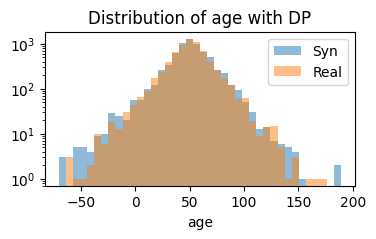

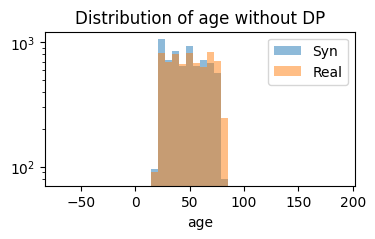

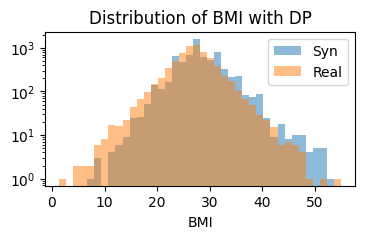

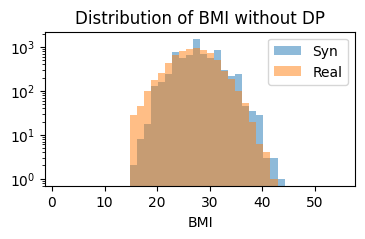

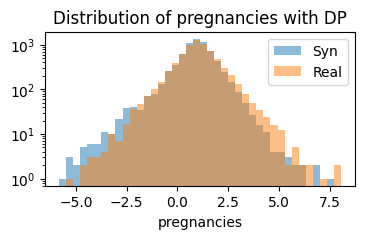

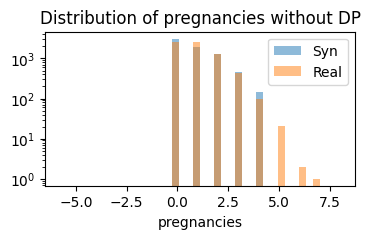

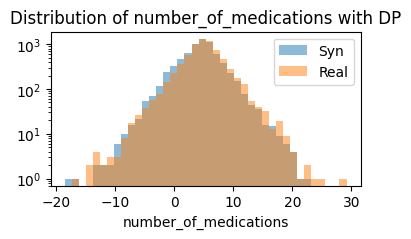

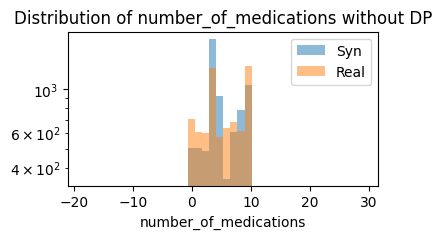

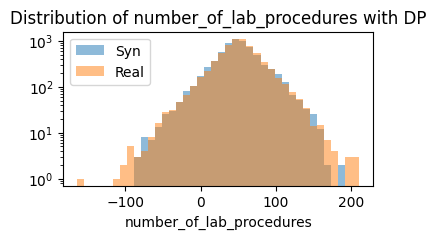

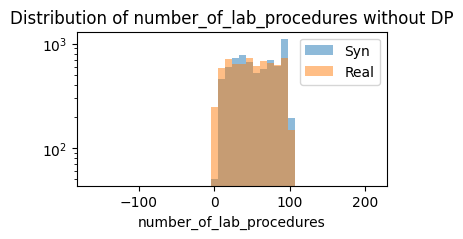

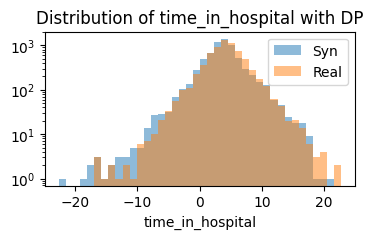

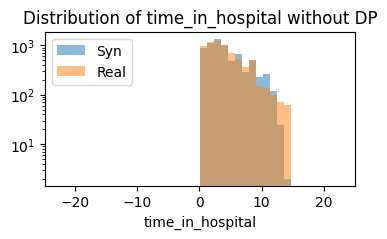

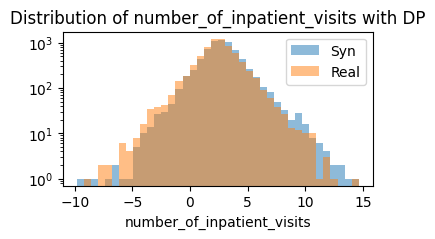

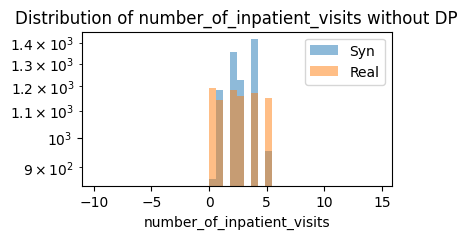

In [16]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import math
from ctgan import CTGAN
import matplotlib.pyplot as plt


synthetic_nodp = pd.read_csv("ct_synthetic_data_nodp.csv").round(0).astype(int)
# Increase recursion limit
sys.setrecursionlimit(30000)


# Differential Privacy Utility
# -------------------------------
def add_dp_noise(df, numeric_cols, cost=0.8):
    """
    Adds Laplace noise to each numeric column in the dataframe.
    Assumes a sensitivity of 1 for each column.
    The noise scale is computed as sensitivity / cost.
    With cost = 5, the scale is 1/5 = 0.2.
    """
    noisy_df = df.copy()
    scale = 1.0 / cost
    for col in numeric_cols:
        noise = np.random.laplace(loc=df[col].mean(), scale=df[col].std(), size=noisy_df.shape[0])
        noisy_df[col] = noisy_df[col] * (1 - cost) + noise * cost
    return noisy_df

# -------------------------------
# Fair Matching (FIDR/IDR) Functions
# -------------------------------

'''
def match_exists_fair(row, other_df, QI_cat, QI_num, epsilon_dict):
    """
    Returns True if there exists at least one record in other_df that:
      - Matches exactly on each categorical quasi-identifier (QI_cat), and
      - For each numeric quasi-identifier in QI_num, the absolute difference 
        between the values is less than the corresponding epsilon in epsilon_dict.
    """
    # Filter other_df to those rows matching categorical fields exactly.
    subset = other_df.copy()
    for col in QI_cat:
        subset = subset[subset[col] == row[col]]
    if subset.empty:
        return False
    # Check each candidate: for each numeric feature, difference must be < epsilon_dict[col]
    for _, candidate in subset.iterrows():
        all_match = True
        for col in QI_num:
            tol = epsilon_dict.get(col, 1)
            if abs(row[col] - candidate[col]) >= tol:
                all_match = False
                break
        if all_match:
            return True
    return False
'''
'''
def compute_risk_fair(df_real, df_syn, QI_cat, QI_num, epsilon_dict):
    """
    Computes a risk measure:
      Risk = max( (1/N)*sum_{s in real}(I_s / f_s), (1/n)*sum_{s in synthetic}(I_s / F_s) )
    where for each record s, I_s = 1 if a match exists (using the fair matching criteria),
    and f_s (or F_s) is the frequency (group size) for that record’s categorical group.
    """
    # Compute group frequencies for df_real
    groups_real = df_real.groupby(QI_cat).size().to_dict()
    risk_real = 0
    for _, row in df_real.iterrows():
        I = 1 if match_exists_fair(row, df_syn, QI_cat, QI_num, epsilon_dict) else 0
        group_key = tuple(row[col] for col in QI_cat)
        f = groups_real.get(group_key, 1)
        risk_real += I / f
    risk_real /= len(df_real)
    
    # Compute group frequencies for df_syn
    groups_syn = df_syn.groupby(QI_cat).size().to_dict()
    risk_syn = 0
    for _, row in df_syn.iterrows():
        I = 1 if match_exists_fair(row, df_real, QI_cat, QI_num, epsilon_dict) else 0
        group_key = tuple(row[col] for col in QI_cat)
        f = groups_syn.get(group_key, 1)
        risk_syn += I / f
    risk_syn /= len(df_syn)
    
    return max(risk_real, risk_syn)

def compute_FIDR(df_real, df_syn, QI_cat, QI_num, epsilon_dict):
    """
    Computes Fair Identity Disclosure Risk, allowing per-feature tolerances.
    """
    return compute_risk_fair(df_real, df_syn, QI_cat, QI_num, epsilon_dict)

def compute_IDR(df_real, df_syn, QI_cat, QI_num):
    """
    Computes Identity Disclosure Risk using exact matching (i.e., zero tolerance).
    """
    eps_dict = {col: 0 for col in QI_num}
    return compute_risk_fair(df_real, df_syn, QI_cat, QI_num, eps_dict)
'''
# -------------------------------
# Data Simulation Utilities
# -------------------------------
def ensure_numeric_column(df, col, simulation_func):
    if col not in df.columns or df[col].isna().all():
        df[col] = simulation_func(len(df))
    else:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        missing_mask = df[col].isna()
        if missing_mask.sum() > 0:
            df.loc[missing_mask, col] = simulation_func(missing_mask.sum())
    return df[col]

def add_additional_feature(df, col, simulation_func):
    if col not in df.columns:
        df[col] = simulation_func(len(df))
    else:
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        except Exception:
            pass
        missing_mask = df[col].isna()
        if missing_mask.sum() > 0:
            df.loc[missing_mask, col] = simulation_func(missing_mask.sum())
    return df[col]

# -------------------------------
# Linking External Data Functions
# -------------------------------
def link_bmi_data(sim_df, bmi_file='bmi.csv'):
    """
    For each row in the simulated dataframe, sample from the BMI dataset to assign height and weight.
    Compute BMI as: BMI = weight / ((height / 100) ** 2) and update the simulated row.
    """
    bmi_df = pd.read_csv(bmi_file)
    bmi_df.columns = [col.lower() for col in bmi_df.columns]
    if 'height' not in bmi_df.columns or 'weight' not in bmi_df.columns:
        raise KeyError("BMI CSV must contain 'height' and 'weight' columns.")
    bmi_df['bmi'] = bmi_df['weight'] / ((bmi_df['height'] / 100) ** 2)
    
    def sample_bmi(row):
        gender_val = row['gender']
        subset = bmi_df[bmi_df['gender'] == gender_val]
        if subset.empty:
            return row
        sample = subset.sample(n=1).iloc[0]
        row['height'] = sample['height']
        row['weight'] = sample['weight']
        row['BMI'] = sample['bmi']
        return row
    sim_df = sim_df.apply(sample_bmi, axis=1)
    return sim_df

def link_diabetes_data(sim_df, diabetes_file='diabetes.csv'):
    """
    For each row in the simulated dataframe, use the linked BMI and age values
    to find the nearest neighbor in the diabetes dataset.
    (This function does not update any clinical columns.)
    """
    diabetes_df = pd.read_csv(diabetes_file)
    diabetes_df.columns = [col.lower() for col in diabetes_df.columns]
    def sample_diabetes(row):
        a = row['age']
        bmi_val = row['BMI']
        distances = np.sqrt((diabetes_df['age'] - a)**2 + (diabetes_df['bmi'] - bmi_val)**2)
        idx = distances.idxmin()
        return row
    sim_df = sim_df.apply(sample_diabetes, axis=1)
    return sim_df

# -------------------------------
# Main Code: Data Generation, Linking, Synthetic Data Generation, and Evaluation
# -------------------------------
def main():
    # Load the initial diabetic dataset (seed)
    df = pd.read_csv('diabetic_data.csv')
    print("Original diabetic dataset shape:", df.shape)
    if len(df) > 10000:
        df = df.sample(n=10000, random_state=42)
    print("Dataset shape after limiting to 10,000 rows:", df.shape)
    
    # Process quasi-identifiers
    df['age'] = ensure_numeric_column(df, 'age', lambda n: np.random.randint(20, 81, size=n))
    df['BMI'] = ensure_numeric_column(df, 'BMI', lambda n: np.clip(np.random.normal(loc=27, scale=4, size=n), 15, 50))
    df['pregnancies'] = ensure_numeric_column(df, 'pregnancies', lambda n: np.random.poisson(lam=1, size=n))
    if 'gender' not in df.columns or df['gender'].isna().all():
        df['gender'] = np.random.choice([0, 1], size=len(df))
    else:
        df['gender'] = pd.to_numeric(df['gender'], errors='coerce')
        missing_mask = df['gender'].isna()
        if missing_mask.sum() > 0:
            df.loc[missing_mask, 'gender'] = np.random.choice([0, 1], size=missing_mask.sum())
    if 'marital_status' not in df.columns or df['marital_status'].isna().all():
        df['marital_status'] = np.random.choice([0, 1, 2], size=len(df), p=[0.3, 0.6, 0.1])
    else:
        df['marital_status'] = pd.to_numeric(df['marital_status'], errors='coerce')
        missing_mask = df['marital_status'].isna()
        if missing_mask.sum() > 0:
            df.loc[missing_mask, 'marital_status'] = np.random.choice([0, 1, 2], size=missing_mask.sum(), p=[0.3, 0.6, 0.1])
    
    # Process additional features
    df['number_of_medications'] = add_additional_feature(df, 'number_of_medications', lambda n: np.random.randint(0, 11, size=n))
    df['number_of_lab_procedures'] = add_additional_feature(df, 'number_of_lab_procedures', lambda n: np.random.randint(1, 101, size=n))
    df['time_in_hospital'] = add_additional_feature(df, 'time_in_hospital', lambda n: np.random.randint(1, 15, size=n))
    df['number_of_inpatient_visits'] = add_additional_feature(df, 'number_of_inpatient_visits', lambda n: np.random.randint(0, 6, size=n))
    df.fillna(method='ffill', inplace=True)
    
    # Create final simulated dataset
    qi_cols = ['age', 'gender', 'BMI', 'marital_status', 'pregnancies']
    additional_features = ['number_of_medications', 'number_of_lab_procedures', 'time_in_hospital', 'number_of_inpatient_visits']
    simulated_df = df[qi_cols + additional_features].copy()
    simulated_df['BMI'] = simulated_df['BMI'].round(1)
    simulated_df['gender'] = simulated_df['gender'].astype(object)
    simulated_df['marital_status'] = simulated_df['marital_status'].astype(object)
    simulated_df['target'] = (simulated_df['BMI'] > 30).astype(int)
    
    # Link external data
    simulated_df = link_bmi_data(simulated_df, bmi_file='bmi.csv')
    simulated_df = link_diabetes_data(simulated_df, diabetes_file='diabetes.csv')
    print("\nSimulated dataset head after linking external data:")
    print(simulated_df.head())
    
    

    
    # --------------------------
    # Split Data & Train TVAE Synthesizer with Metadata
    # --------------------------
    final_cols = qi_cols + additional_features + ['target']
    train_df, holdout_df = train_test_split(simulated_df[final_cols], test_size=0.3, random_state=42)
    holdout_df=holdout_df.sample(frac=0.3,random_state=42)
    print("\nTrainset size:", len(train_df))
    print("Holdout set size:", len(holdout_df))

        
    # ---- Add Differential Privacy Noise ----
    numeric_cols_dp = ['age', 'BMI', 'pregnancies', 'number_of_medications', 
                       'number_of_lab_procedures', 'time_in_hospital', 'number_of_inpatient_visits']
    train_df_1 = add_dp_noise(train_df, numeric_cols_dp, cost=0.8)
    print("\nSimulated dataset head (after DP noise):")
    print(simulated_df.head())
    
    model = CTGAN(epochs=200,verbose=True, generator_dim=(128, 128), discriminator_dim=(128, 128))
    model.fit(train_df_1)
    synthetic_df = model.sample(len(train_df))
    
    synthetic_df['age'] = synthetic_df['age'].round(0).astype(int)
    synthetic_df['gender'] = synthetic_df['gender'].round(0).astype(int).astype(object)
    synthetic_df['BMI'] = synthetic_df['BMI'].round(1).astype(int)
    synthetic_df['target'] = synthetic_df['target'].round(0).astype(int)
    
    print("\nSynthetic dataset head:")
    print(synthetic_df.head())

    simulated_df.to_csv("simulated_data.csv", index=False)
    synthetic_df.to_csv("ct_synthetic_data_withdp.csv", index=False)
    train_df.to_csv('ct_train_data_withdp.csv', index=False)
    holdout_df.to_csv('ct_holdout_data_withdp.csv', index=False)
    
    # Utility evaluation using logistic regression
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_auc_score
    util_features = qi_cols + additional_features  # exclude target
    X_syn = synthetic_df[util_features]
    y_syn = synthetic_df['target']
    X_holdout = holdout_df[util_features]
    y_holdout = holdout_df['target']
    
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_syn, y_syn)
    y_pred_proba = clf.predict_proba(X_holdout)[:,1]
    auc = roc_auc_score(y_holdout, y_pred_proba)
    print("\nUtility Evaluation (AUC of logistic regression trained on synthetic data): {:.8f}".format(auc))
    
    # Fidelity evaluation using Hellinger distance for numeric columns
    def hellinger_distance(p, q):
        return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2))
    numeric_cols = ['age', 'BMI', 'pregnancies', 'number_of_medications',
                    'number_of_lab_procedures', 'time_in_hospital', 'number_of_inpatient_visits']
    print("\nFidelity Evaluation (Hellinger distances):")
    for col in numeric_cols:
        holdout_hist, bin_edges = np.histogram(train_df[col], bins=10, density=True)
        synthetic_hist, _ = np.histogram(synthetic_df[col], bins=bin_edges, density=True)
        holdout_hist = holdout_hist / holdout_hist.sum()
        synthetic_hist = synthetic_hist / synthetic_hist.sum()
        h_dist = hellinger_distance(holdout_hist, synthetic_hist)
        print("  {}: Hellinger distance = {:.8f}".format(col, h_dist))
    for col in numeric_cols:
    # Combine both datasets to define common bin edges
        data_combined = np.concatenate([train_df[col].values, train_df_1[col].values,synthetic_df[col].values,synthetic_nodp[col].values])
        bin_edges = np.histogram_bin_edges(data_combined, bins=40)
    
        plt.figure(figsize=(4,2))
        
        plt.hist(synthetic_df[col], bins=bin_edges, alpha=0.5, density=False, label='Syn')
        plt.hist(train_df_1[col], bins=bin_edges, alpha=0.5, density=False, label='Real')
        plt.title(f"Distribution of {col} with DP")
        plt.xlabel(col)
        plt.yscale('log')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(4, 2))
        plt.hist(synthetic_nodp[col], bins=bin_edges, alpha=0.5, density=False, label='Syn')
        plt.hist(train_df[col], bins=bin_edges, alpha=0.5, density=False, label='Real')
        plt.title(f"Distribution of {col} without DP")
        plt.xlabel(col)
        plt.yscale('log')
        plt.legend()
        plt.show()

if __name__ == "__main__":
    main() 

In [12]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist


train = pd.read_csv("ct_train_data_withdp.csv").round(0).astype(int)
holdout = pd.read_csv("ct_holdout_data_withdp.csv").round(0).astype(int)
synthetic = pd.read_csv("ct_synthetic_data_withdp.csv").round(0).astype(int)

# Test each of the two combinations for synthetic data generated from each model and with different DP settings 
# simulated = holdout set, synthetic = synthetic -> holdout set IDR and FIDR
# simulated = training set, synthetic = synthetic -> training set IDR and FIDR

# age,gender,BMI,marital_status,pregnancies,number_of_medications,number_of_lab_procedures,time_in_hospital,number_of_inpatient_visits,target

# Quasi ID
QI = [
        "gender", 
        "marital_status", 
        "age",
        "BMI",
        "pregnancies",
        "number_of_medications",
        #"number_of_lab_procedures",
        #"time_in_hospital",
        #"number_of_inpatient_visits"
]

# Quasi ID + Sensitive variables
qi_sv = [
        "gender", 
        "marital_status", 
        "age",
        "BMI",
        "pregnancies",
        "number_of_medications",
        #"number_of_lab_procedures",
        #"time_in_hospital",
        #"number_of_inpatient_visits"
]

numerical = [
    "age",
    #"BMI",
    #"pregnancies",
    #"number_of_lab_procedures",
]

def add(df, u):
    c = df.copy()
    ldf = df[qi_sv].values.tolist()
    ldf = ["_".join([str(int(v)) for v in r]) in u for r in ldf] # in u or test_u
    c['ls_rs'] = np.where(ldf, 1, 0)
    ldf = df[QI].values.tolist()
    ldf = ["_".join([str(v) for v in r]) for r in ldf]
    cldf = Counter(ldf)
    c['QI'] = ldf
    c['QI_count'] = [cldf[r] for r in c['QI']]
    return c

def combinations(df):
    col = QI + ['key', 'count']
    ldf = df[QI].values.tolist()
    ldf = ["_".join([str((v)) for v in r]) for r in ldf]
    cldf = Counter(ldf)
    ldf = [k.split("_") + [k, v] for k, v in list(cldf.items())]
    fdf = pd.DataFrame(ldf, columns=col).sort_values(by=['count'], ascending=False)
    return fdf

def compute_idr(real, syn, numerical, noise):
    categorical = list(set(QI) - set(numerical))
    cols = categorical + numerical

    real = real[cols]
    syn = syn[cols]

    rdf = combinations(real)
    sdf = combinations(syn)

    sd = set(sdf['key'].tolist())
    rd = set(rdf['key'].tolist())

    sd_dict = {}
    for v in sd:
        v = v.split("_")
        k = "_".join([v[i] for i in range(len(categorical))])
        if k not in sd_dict:
            sd_dict[k] = []
        sd_dict[k].append([float(v[i]) for i in range(len(categorical), len(cols))])

    rd_dict = {}
    for v in rd:
        v = v.split("_")
        k = "_".join([v[i] for i in range(len(categorical))])
        if k not in rd_dict:
            rd_dict[k] = []
        rd_dict[k].append([float(v[i]) for i in range(len(categorical), len(cols))])

    test_u = []
    for k,v in sd_dict.items():
        if k in rd_dict:
            w = rd_dict[k]
            
            v = np.array(v).astype(int)
            w = np.array(w).astype(int)

            d = cdist(w,v, metric="cityblock")
            d = np.where(d <= noise, 1, 0)
            w_add = d.sum(axis=1)
            v_add = d.sum(axis=0)
            
            
            for i, c in enumerate(w_add):
                if c > 0:
                    n = "_".join([k] + [str(w[i][idx]) for idx in range(len(cols)-len(categorical))])
                    test_u.append(n)
            
            for i, c in enumerate(v_add):
                if c > 0:
                    n = "_".join([k] + [str(v[i][idx]) for idx in range(len(cols)-len(categorical))])
                    test_u.append(n)

    test_u = set(test_u)
    u = set.intersection(sd,rd)

    ss = sdf.sum()
    rs = rdf.sum()

    rdf = add(real, u)
    sdf = add(syn, u)
    sr = (1/sdf['QI_count']).mul(sdf['ls_rs']/rs['count']).sum()
    rr = (1/rdf['QI_count']).mul(rdf['ls_rs']/ss['count']).sum()
    
    
    print("idr", f"{sr:.3e}", f"{rr:.3e}")


    rdf = add(real, test_u)
    sdf = add(syn, test_u)
    sr = (1/sdf['QI_count']).mul(sdf['ls_rs']/rs['count']).sum()
    rr = (1/rdf['QI_count']).mul(rdf['ls_rs']/ss['count']).sum()
    
    
    print("fidr", f"{sr:.3e}", f"{rr:.3e}")
    

    
compute_idr(train, holdout, numerical, 1)
compute_idr(train, synthetic, numerical, 1)

compute_idr(train, holdout, numerical, 2)
compute_idr(train, synthetic, numerical, 2)

compute_idr(train, holdout, numerical, 3)
compute_idr(train, synthetic, numerical, 3)

# --- Additional Code for Subtraction of IDR and FIDR ---

def compute_idr_values(real, syn, numerical, noise):
    # Use the same QI and qi_sv as defined earlier.
    categorical = list(set(QI) - set(numerical))
    cols = categorical + numerical

    real_sub = real[cols]
    syn_sub = syn[cols]

    rdf = combinations(real_sub)
    sdf = combinations(syn_sub)

    sd = set(sdf['key'].tolist())
    rd = set(rdf['key'].tolist())

    sd_dict = {}
    for v in sd:
        parts = v.split("_")
        k = "_".join(parts[:len(categorical)])
        sd_dict.setdefault(k, []).append([float(x) for x in parts[len(categorical):]])
    rd_dict = {}
    for v in rd:
        parts = v.split("_")
        k = "_".join(parts[:len(categorical)])
        rd_dict.setdefault(k, []).append([float(x) for x in parts[len(categorical):]])

    test_u = []
    for k, v in sd_dict.items():
        if k in rd_dict:
            w = rd_dict[k]
            v_arr = np.array(v).astype(int)
            w_arr = np.array(w).astype(int)
            # Calculate pairwise Manhattan distances
            d = cdist(w_arr, v_arr, metric="cityblock")
            d = np.where(d <= noise, 1, 0)
            w_add = d.sum(axis=1)
            v_add = d.sum(axis=0)
            for i, count in enumerate(w_add):
                if count > 0:
                    n = "_".join([k] + [str(w_arr[i][j]) for j in range(v_arr.shape[1])])
                    test_u.append(n)
            for i, count in enumerate(v_add):
                if count > 0:
                    n = "_".join([k] + [str(v_arr[i][j]) for j in range(v_arr.shape[1])])
                    test_u.append(n)

    test_u = set(test_u)
    u = set.intersection(sd, rd)
    
    # Using the count sums from combinations DataFrames
    ss = sdf['count'].sum()
    rs = rdf['count'].sum()
    
    # IDR calculation using the intersection u
    rdf_u = add(real_sub, u)
    sdf_u = add(syn_sub, u)
    idr_sr = (1 / sdf_u['QI_count']).mul(sdf_u['ls_rs'] / rs).sum()
    idr_rr = (1 / rdf_u['QI_count']).mul(rdf_u['ls_rs'] / ss).sum()
    idr_val = max(idr_sr, idr_rr)
    
    # FIDR calculation using test_u
    rdf_t = add(real_sub, test_u)
    sdf_t = add(syn_sub, test_u)
    fidr_sr = (1 / sdf_t['QI_count']).mul(sdf_t['ls_rs'] / rs).sum()
    fidr_rr = (1 / rdf_t['QI_count']).mul(rdf_t['ls_rs'] / ss).sum()
    fidr_val = max(fidr_sr, fidr_rr)
    
    return idr_val, fidr_val

# For each noise level, compute IDR and FIDR for train vs holdout and train vs synthetic,
# then subtract the holdout value (larger one) from the synthetic value (larger one).
for noise in [1, 2, 3]:
    idr_holdout, fidr_holdout = compute_idr_values(train, holdout, numerical, noise)
    idr_synthetic, fidr_synthetic = compute_idr_values(train, synthetic, numerical, noise)
    
    diff_idr = idr_synthetic - idr_holdout
    diff_fidr = fidr_synthetic - fidr_holdout

    print(f"Noise {noise}: Difference in IDR (train vs synthetic - train vs holdout) = {diff_idr:.3e}")
    print(f"Noise {noise}: Difference in FIDR (train vs synthetic - train vs holdout) = {diff_fidr:.3e}")





#compute_idr(simulated, synthetic,numerical,3)

idr 8.571e-03 6.667e-02
fidr 1.871e-02 1.600e-01
idr 3.457e-02 3.457e-02
fidr 8.900e-02 8.943e-02
idr 8.571e-03 6.667e-02
fidr 2.700e-02 2.433e-01
idr 3.457e-02 3.457e-02
fidr 1.330e-01 1.346e-01
idr 8.571e-03 6.667e-02
fidr 3.557e-02 3.389e-01
idr 3.457e-02 3.457e-02
fidr 1.743e-01 1.747e-01
Noise 1: Difference in IDR (train vs synthetic - train vs holdout) = -3.210e-02
Noise 1: Difference in FIDR (train vs synthetic - train vs holdout) = -7.057e-02
Noise 2: Difference in IDR (train vs synthetic - train vs holdout) = -3.210e-02
Noise 2: Difference in FIDR (train vs synthetic - train vs holdout) = -1.088e-01
Noise 3: Difference in IDR (train vs synthetic - train vs holdout) = -3.210e-02
Noise 3: Difference in FIDR (train vs synthetic - train vs holdout) = -1.642e-01


SyntaxError: invalid decimal literal (2936648488.py, line 1)